# Sequence-to-Sequence Model with Attention

In [57]:
from collections import Counter

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from nltk import wordpunct_tokenize
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import Dataset
from tqdm import tqdm


In [41]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cpu')

In [42]:
def tokenize(text):
    """
    Turn text into discrete tokens.

    Remove tokens that are not words.
    """
    text = str(text).lower()
    tokens = wordpunct_tokenize(text)

    # Only keep words
    tokens = [token for token in tokens
              if all(char.isalpha() for char in token)]

    return tokens


class SourceTargetTranslations(Dataset):
    #def __init__(self, path, max_vocab):
    def __init__(self, df, max_vocab):
    
        self.max_vocab = max_vocab
        
        # Extra tokens to add
        self.padding_token = '<PAD>'
        self.start_of_sequence_token = '<SOS>'
        self.end_of_sequence_token = '<EOS>'
        self.unknown_word_token = '<UNK>'
        
        # Helper function
        self.flatten = lambda x: [sublst for lst in x for sublst in lst]
        
        # Load the data into a DataFrame
        print(df.head())
        # Tokenize inputs (source) and targets (target)
        self.tokenize_df(df)

        # To reduce computational complexity, replace rare words with <UNK>
        self.replace_rare_tokens(df)
        
        # Prepare variables with mappings of tokens to indices
        self.create_token2idx(df)
        
        # Remove sequences with mostly <UNK>
        df = self.remove_mostly_unk(df)
        
        # Every sequence (input and target) should start with <SOS>
        # and end with <EOS>
        self.add_start_and_end_to_tokens(df)
        
        # Convert tokens to indices
        self.tokens_to_indices(df)
        
    def __getitem__(self, idx):
        """Return example at index idx."""
        return self.indices_pairs[idx][0], self.indices_pairs[idx][1]
    
    def tokenize_df(self, df):
        """Turn inputs and targets into tokens."""
        df['tokens_inputs'] = df["source"].apply(tokenize)
        df['tokens_targets'] = df["target"].apply(tokenize)
        
    def replace_rare_tokens(self, df):
        """Replace rare tokens with <UNK>."""
        common_tokens_inputs = self.get_most_common_tokens(
            df.tokens_inputs.tolist(),
        )
        common_tokens_targets = self.get_most_common_tokens(
            df.tokens_targets.tolist(),
        )
        
        df.loc[:, 'tokens_inputs'] = df.tokens_inputs.apply(
            lambda tokens: [token if token in common_tokens_inputs 
                            else self.unknown_word_token for token in tokens]
        )
        df.loc[:, 'tokens_targets'] = df.tokens_targets.apply(
            lambda tokens: [token if token in common_tokens_targets
                            else self.unknown_word_token for token in tokens]
        )

    def get_most_common_tokens(self, tokens_series):
        """Return the max_vocab most common tokens."""
        all_tokens = self.flatten(tokens_series)
        # Substract 4 for <PAD>, <SOS>, <EOS>, and <UNK>
        common_tokens = set(list(zip(*Counter(all_tokens).most_common(
            self.max_vocab - 4)))[0])
        return common_tokens

    def remove_mostly_unk(self, df, threshold=0.99):
        """Remove sequences with mostly <UNK>."""
        def calculate_ratio(tokens):
            # Check if tokens list is empty to avoid division by zero
            if len(tokens) == 0:
                return False  # Consider returning True if you want to remove empty token lists
            return (sum(1 for token in tokens if token != '<UNK>') / len(tokens)) > threshold

        # Apply the function to the DataFrame columns
        df = df[df['tokens_inputs'].apply(calculate_ratio)]
        df = df[df['tokens_targets'].apply(calculate_ratio)]
        return df

    def create_token2idx(self, df):
        """Create variables with mappings from tokens to indices."""
        unique_tokens_inputs = set(self.flatten(df.tokens_inputs))
        unique_tokens_targets = set(self.flatten(df.tokens_targets))
        
        for token in reversed([
            self.padding_token,
            self.start_of_sequence_token,
            self.end_of_sequence_token,
            self.unknown_word_token,
        ]):
            if token in unique_tokens_inputs:
                unique_tokens_inputs.remove(token)
            if token in unique_tokens_targets:
                unique_tokens_targets.remove(token)
                
        unique_tokens_inputs = sorted(list(unique_tokens_inputs))
        unique_tokens_targets = sorted(list(unique_tokens_targets))

        # Add <PAD>, <SOS>, <EOS>, and <UNK> tokens
        for token in reversed([
            self.padding_token,
            self.start_of_sequence_token,
            self.end_of_sequence_token,
            self.unknown_word_token,
        ]):
            
            unique_tokens_inputs = [token] + unique_tokens_inputs
            unique_tokens_targets = [token] + unique_tokens_targets
            
        self.token2idx_inputs = {token: idx for idx, token
                                 in enumerate(unique_tokens_inputs)}
        self.idx2token_inputs = {idx: token for token, idx
                                 in self.token2idx_inputs.items()}
        
        self.token2idx_targets = {token: idx for idx, token
                                  in enumerate(unique_tokens_targets)}
        self.idx2token_targets = {idx: token for token, idx
                                  in self.token2idx_targets.items()}
        
    def add_start_and_end_to_tokens(self, df):
        """Add <SOS> and <EOS> tokens to the end of every input and output."""
        df['tokens_inputs'] = df['tokens_inputs'].apply(
            lambda tokens: [self.start_of_sequence_token] + tokens + [self.end_of_sequence_token]
        )
        df['tokens_targets'] = df['tokens_targets'].apply(
            lambda tokens: [self.start_of_sequence_token] + tokens + [self.end_of_sequence_token]
        )
        
    def tokens_to_indices(self, df):
        """Convert tokens to indices."""
        df['indices_inputs'] = df.tokens_inputs.apply(
            lambda tokens: [self.token2idx_inputs[token] for token in tokens])
        df['indices_targets'] = df.tokens_targets.apply(
            lambda tokens: [self.token2idx_targets[token] for token in tokens])
             
        self.indices_pairs = list(zip(df.indices_inputs, df.indices_targets))
        
    def __len__(self):
        return len(self.indices_pairs)

In [43]:
def read_file(file_path,fraction):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.readlines()  # reads all lines into a list
        
    # Remove newline characters at the end of each line
    content = [line.strip() for line in content]
    
    # Calculate the number of lines to return based on the fraction
    if 0 < fraction < 1:
        end_index = int(len(content) * fraction)
        return content[:end_index]
    else:
        return content[:fraction]  # Return the full list



In [44]:
#### TRANSFORM OUR DATA IN THE DESIRED FORMAT#########

In [45]:
max_words = 5
fraction = 20000000
source_file_path = "fr-en/europarl-v7.fr-en.en"
target_file_path = "fr-en/europarl-v7.fr-en.fr"

# Assuming read_file function is correctly implemented and returns the data needed
source_data = read_file(source_file_path, fraction)
target_data = read_file(target_file_path, fraction)


In [60]:
# Creating new lists that only include entries with <= max_words
max_words = 5  # Setting the max words limit, as per your example
filtered_source_data = []
filtered_target_data = []

for source, target in zip(source_data, target_data):
    word_source = source.split(" ")
    word_target = target.split(" ")
    if len(word_source) <= max_words and len(word_target) <= max_words:
        filtered_source_data.append(source)
        filtered_target_data.append(target)

print(len(filtered_source_data))
    


56641


In [47]:
df = pd.DataFrame({
    'source': filtered_source_data,
    'target': filtered_target_data
})

dataset = SourceTargetTranslations(df, max_vocab=2000)

len(dataset)

                          source                            target
0      Resumption of the session             Reprise de la session
1                         Agenda                 Ordre des travaux
2  (Applause from the PSE Group)  (Applaudissements du groupe PSE)
3      Thank you, Mr Poettering.        Merci Monsieur Poettering.
4           Thank you very much.                            Merci.


36955

In [48]:
i = 4201
print(df["source"][i])
print(df["target"][i])

Environmental policy
Politique de l'environnement


In [49]:
def collate(batch):
    inputs = [torch.LongTensor(item[0]) for item in batch]
    targets = [torch.LongTensor(item[1]) for item in batch]
    
    # Pad sequencse so that they are all the same length (within one minibatch)
    padded_inputs = pad_sequence(inputs, padding_value=dataset.token2idx_targets[dataset.padding_token], batch_first=True)
    padded_targets = pad_sequence(targets, padding_value=dataset.token2idx_targets[dataset.padding_token], batch_first=True)
    
    # Sort by length for CUDA optimizations
    lengths = torch.LongTensor([len(x) for x in inputs])
    lengths, permutation = lengths.sort(dim=0, descending=True)

    return padded_inputs[permutation].to(device), padded_targets[permutation].to(device), lengths.to(device)




### Define the Encoder

In [50]:

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, batch_size, pretrained_embeddings):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings)  # Set pretrained weights
        self.embedding.weight.requires_grad = True  # Optionally, make embeddings trainable
        self.gru = nn.GRU(self.embedding_dim, self.hidden_size, batch_first=True)
    
    # Remaining methods remain unchanged
        
    def forward(self, inputs, lengths):
        self.batch_size = inputs.size(0)
        
        # Turn input indices into distributed embeddings
        x = self.embedding(inputs)

        # Remove padding for more efficient RNN application
        x = pack_padded_sequence(x, lengths, batch_first=True)
    
        # Apply RNN to get hidden state at all timesteps (output)
        # and hidden state of last output (self.hidden)
        output, self.hidden = self.gru(x, self.init_hidden())
        
        # Pad the sequences like they were before
        output, _ = pad_packed_sequence(output)
        
        return output, self.hidden

    def init_hidden(self):
        # Randomly initialize the weights of the RNN
        return torch.randn(1, self.batch_size, self.hidden_size).to(device)

### Define the Decoder

In [51]:
class Decoder(nn.Module):
    def __init__(
        self, 
        vocab_size,
        embedding_dim, 
        decoder_hidden_size,
        encoder_hidden_size, 
        batch_size,
        pretrained_embeddings
    ):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings)  # Set pretrained weights
        self.embedding.weight.requires_grad = True  # Optionally, make embeddings trainable
        self.gru = nn.GRU(
            self.embedding_dim + self.encoder_hidden_size, 
            self.decoder_hidden_size,
            batch_first=True,
        )
        self.fc = nn.Linear(self.encoder_hidden_size, self.vocab_size)
        
        # Attention weights
        self.W1 = nn.Linear(self.encoder_hidden_size, self.decoder_hidden_size)
        self.W2 = nn.Linear(self.encoder_hidden_size, self.decoder_hidden_size)
        self.V = nn.Linear(self.encoder_hidden_size, 1)
    
    def forward(self, targets, hidden, encoder_output):
        # target = (batch_size, 1)
        self.batch_size = targets.size(0)
        
        # Switch the dimensions of sequence_length and batch_size
        encoder_output = encoder_output.permute(1, 0, 2)
        # encoder_output = (batch_size, sequence_length, hidden_size)

        # Add an extra axis for a time dimension
        # hidden = (1, batch_size, hidden_size)
        hidden_with_time_axis = hidden.permute(1, 0, 2)
        # hidden_with_time_axis = (batch_size, 1, hidden_size)

        # Attention score (Bahdanaus)
        score = torch.tanh(self.W1(encoder_output) + self.W2(hidden_with_time_axis))
        # score = (batch_size, sequence_length, hidden_size)

        # Attention weights
        attention_weights = torch.softmax(self.V(score), dim=1)
        # attention_weights = (batch_size, sequence_length, 1)

        # Find the context vectors
        context_vector = attention_weights * encoder_output
        # context_vector = (batch_size, sequence_length, hidden_size)
        context_vector = torch.sum(context_vector, dim=1)
        # context_vector = (batch_size, hidden_size)
        
        # Turn target indices into distributed embeddings
        x = self.embedding(targets)
        # x = (batch_size, 1, embedding_dim)
        
        # Add the context representation to the target embeddings
        x = torch.cat((context_vector.unsqueeze(1), x), -1)
        # x = (batch_size, 1, embedding_dim + hidden_size)

        # Apply the RNN
        # RuntimeError: Expected hidden size (1, 1, 256), got [1, 256, 256]
        output, state = self.gru(x, self.init_hidden())
        # output = (batch_size, 1, hidden_size)
        # state = (1, batch_size, hidden_size)
        
        # Reshape the hidden states (output)
        output = output.view(-1, output.size(2))
        # output = (batch_size, hidden_size)
        
        # Apply a linear layer
        x = self.fc(output)
        # x = (batch_size, vocab_size)
        
        return x, state, attention_weights
    
    def init_hidden(self):
        # Randomly initialize the weights of the RNN
        return torch.randn(1, self.batch_size, self.decoder_hidden_size).to(device)

### Define a model that has both an Encoder and Decoder

In [52]:
criterion = nn.CrossEntropyLoss()

def loss_function(real, pred):
    """Calculate how wrong the model is."""
    # Use mask to only consider non-zero inputs in the loss
    mask = real.ge(1).float().to(device)
    
    loss_ = criterion(pred, real) * mask 
    return torch.mean(loss_)


class EncoderDecoder(nn.Module):
    def __init__(self, inputs_vocab_size, targets_vocab_size, hidden_size,
                 embedding_dim, batch_size, targets_start_idx, targets_stop_idx,
                 encoder_embeddings, decoder_embeddings):  # Added embeddings parameters
        super(EncoderDecoder, self).__init__()
        self.batch_size = batch_size
        self.targets_start_idx = targets_start_idx
        self.targets_stop_idx = targets_stop_idx
        
        # Pass pretrained embeddings to the encoder and decoder
        self.encoder = Encoder(inputs_vocab_size, embedding_dim,
                               hidden_size, batch_size, encoder_embeddings).to(device)
        
        self.decoder = Decoder(targets_vocab_size, embedding_dim,
                               hidden_size, hidden_size, batch_size, decoder_embeddings).to(device)
        
        
    def predict(self, inputs, lengths):
        self.batch_size = inputs.size(0)
        
        encoder_output, context = self.encoder(
            inputs.to(device),
            lengths,
        )
        decoder_hidden = context

        
        # Initialize the input of the decoder to be <SOS>
        decoder_input = torch.LongTensor(
            [[self.targets_start_idx]] * self.batch_size,
        )
        
        # Output predictions instead of loss
        output = []
        attention_matrix = [] #ADDED FOR A

        for _ in range(20): #max sequence length, since we work with short sentences
            #predictions, decoder_hidden, _ = self.decoder( 
            predictions, decoder_hidden, attention_weights = self.decoder( #ADDED FOR A
                decoder_input.to(device), 
                decoder_hidden.to(device),
                context.to(device),
                )
           
            prediction = torch.multinomial(F.softmax(predictions, dim=1), 1)
            decoder_input = prediction

            prediction = prediction.item()
            output.append(prediction)
            attention_matrix.append(attention_weights.cpu().numpy())


            if prediction == self.targets_stop_idx:
                return output,  np.stack(attention_matrix)

        #return output
        return output, np.stack(attention_matrix) #ADDED FOR A

    def forward(self, inputs, targets, lengths):
        self.batch_size = inputs.size(0)
        
        encoder_output, encoder_hidden = self.encoder(
            inputs.to(device),
            #lengths,
            lengths.cpu(), #CHANGE
        )
        decoder_hidden = encoder_hidden
        
        # Initialize the input of the decoder to be <SOS>
        decoder_input = torch.LongTensor(
            [[self.targets_start_idx]] * self.batch_size,
        )
                
        # Use teacher forcing to train the model. Instead of feeding the model's
        # own predictions to itself, feed the target token at every timestep.
        # This leads to faster convergence
        loss = 0
        for timestep in range(1, targets.size(1)):
            predictions, decoder_hidden, _ = self.decoder(
                decoder_input.to(device), 
                decoder_hidden.to(device),
                encoder_output.to(device),
            )
            decoder_input = targets[:, timestep].unsqueeze(1)
            
            loss += loss_function(targets[:, timestep], predictions)
            
        return loss / targets.size(1)

In [53]:
from typing import Dict
# Example GloVe embedding file path and embedding dimension

def load_glove_embeddings(path: str, word2idx: Dict[str, int], embedding_dim: int) -> torch.Tensor:
    """
    Load GloVe embeddings from a specified file and align them with the given word index dictionary.

    Parameters:
    - path (str): The file path to the GloVe embeddings file.
    - word2idx (Dict[str, int]): A dictionary mapping words to their corresponding indices. This dictionary defines
      the position each word’s vector should occupy in the resulting embedding matrix.
    - embedding_dim (int): The dimensionality of the GloVe vectors (e.g., 50, 100, 200, 300).

    Returns:
    - torch.Tensor: A tensor of shape (len(word2idx), embedding_dim) containing the GloVe vectors aligned according to word2idx.
    """
    with open(path, 'r', encoding='utf-8') as f:
        # Initialize the embedding matrix with zeros
        #embeddings = np.zeros((len(word2idx), embedding_dim))
        #better approach: init with random 
        embeddings = np.random.uniform(-0.1, 0.1, (len(word2idx), embedding_dim))
        # Process each line in the GloVe file
        for line in f:
            values = line.split()
            word = values[0]
            
            # If the word is in the provided dictionary, update the corresponding row in embeddings
            if word in word2idx.keys():
                # Convert embedding values from strings to float32
                vector = np.asarray(values[1:], dtype='float32')
                # Place the vector in the correct index as per word2idx
                embeddings[word2idx[word]] = vector
            else:
                pass
    # Convert the numpy array to a PyTorch tensor
    return torch.from_numpy(embeddings)



def load_word2vec_embeddings(path, word2idx, embedding_dim):
    embeddings = np.random.uniform(-0.1, 0.1, (len(word2idx), embedding_dim))
    with open(path, 'r', encoding='latin1') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            if word in word2idx:
                try:
                    vector = np.asarray(values[1:], dtype='float32')
                    embeddings[word2idx[word]] = vector
                except ValueError:
                    print(f"Error converting values for word: {word}")
                    continue
    return torch.from_numpy(embeddings)






In [54]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


def calc_bleu():
    smoothing_function = SmoothingFunction().method1
    test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=collate, drop_last=True)
    model.eval()
    total_loss = total = 0
    bleu_scores = []
    with torch.no_grad():
        for inputs, targets, lengths in test_loader:
            reference = ' '.join([
                dataset.idx2token_inputs[idx]
                for idx in inputs.cpu()[0].numpy()[1:-1]
            ])
            # print("english:",reference)

            target = ' '.join([
                dataset.idx2token_targets[idx]
                for idx in targets.cpu()[0].numpy()[1:-1]
            ])
            # print("french:",target)

            inputs = inputs.to(device)
            outputs, _ = model.predict(inputs, lengths)
            generated = (' '.join([
                dataset.idx2token_targets[idx]
                for idx in outputs[:-1]
            ]))
            bleu_score = sentence_bleu([target], generated, smoothing_function=smoothing_function)
            bleu_scores.append(bleu_score)

    score = np.mean(bleu_scores)
    return score

In [55]:
from torch.utils.data import DataLoader

batch_size = 256

train_size = int(0.90 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate, drop_last=True)

embedding_dim = 100
hidden_size = 1024

# Load embeddings
word2vec_source_path = 'word2vec/english.txt'
word2vec_target_path = 'word2vec/france.txt'

vocab_source = dataset.token2idx_inputs
vocab_target = dataset.token2idx_targets

vocab_embeddings_source = load_word2vec_embeddings(word2vec_source_path, vocab_source, embedding_dim)
vocab_embeddings_target = load_word2vec_embeddings(word2vec_target_path, vocab_target, embedding_dim)

# Create instances of Encoder and Decoder
encoder = Encoder(vocab_size=len(vocab_source), embedding_dim=embedding_dim, hidden_size=hidden_size, batch_size=batch_size, pretrained_embeddings=vocab_embeddings_source)
decoder = Decoder(vocab_size=len(vocab_target), embedding_dim=embedding_dim, decoder_hidden_size=hidden_size, encoder_hidden_size=hidden_size, batch_size=batch_size, pretrained_embeddings=vocab_embeddings_target)


model = EncoderDecoder(
    inputs_vocab_size=len(dataset.token2idx_inputs),
    targets_vocab_size=len(dataset.token2idx_targets),
    hidden_size=256,
    embedding_dim=embedding_dim, 
    batch_size=batch_size, 
    targets_start_idx=dataset.token2idx_targets[dataset.start_of_sequence_token],
    targets_stop_idx=dataset.token2idx_targets[dataset.end_of_sequence_token],
    encoder_embeddings=vocab_embeddings_source,  # Pass encoder embeddings
    decoder_embeddings=vocab_embeddings_target   # Pass decoder embeddings
).to(device)

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)



Error converting values for word: communauté


In [59]:
epochs=1
# Training loop

for epoch in range(epochs):
    
    total_loss = total = 0
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    for inputs, targets, lengths in progress_bar:
        model.train()
        inputs, targets = inputs.to(device), targets.to(device) #CHANGE ADDED
        lengths = lengths.cpu()  #CHANGE ADDED

        
        # Clean old gradients
        optimizer.zero_grad()

        # Forwards pass
        loss = model(inputs, targets, lengths)

        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()

        # Record metrics
        total_loss += loss.item()
        total += targets.size(1)

    train_loss = total_loss / total
    
    tqdm.write(f'epoch #{epoch + 1:3d}\ttrain_loss: {train_loss:.2e}\tBLEU: {calc_bleu():.4f}\n')
    total_loss = total = 0  

KeyboardInterrupt: 

In [555]:
def translate_text(input_text, model, dataset, device='cpu'):
    model.eval()  # Set the model to evaluation mode

    # Tokenize the input text using the same tokenizer used during training
    tokens = tokenize(input_text)
    # Convert tokens to indices using the source vocabulary
    indices = [dataset.token2idx_inputs.get(token, dataset.token2idx_inputs['<UNK>']) for token in tokens]

    # Add <SOS> and <EOS> tokens
    indices = [dataset.token2idx_inputs[dataset.start_of_sequence_token]] + indices + [dataset.token2idx_inputs[dataset.end_of_sequence_token]]
    
    # Convert list of indices to tensor
    indices_tensor = torch.LongTensor(indices).unsqueeze(0).to(device)  # Add batch dimension
    #print(len(indices_tensor))
    # Create lengths tensor
    lengths = torch.LongTensor([len(indices)]).to(device)

    # Get predictions from the model
    with torch.no_grad():
        
        outputs, attention_weights = model.predict(indices_tensor, lengths)
        #print("attention_weights",attention_weights)
        
       
    # Convert predicted indices back to words
    translation = ' '.join([dataset.idx2token_targets[idx] for idx in outputs[:-1]])
    plot_attention(attention_weights, input_text,translation)

    return translation

In [556]:
input_text = "the debate is closed"
translated_text = translate_text(input_text, model, dataset)
print(translated_text)

ValueError: Must pass 2-d input. shape=(15, 0, 6, 1)

<Figure size 1200x1000 with 0 Axes>

In [598]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention(attention_weights, input_sequence, output_sequence):
    input_sequence = input_sequence.split(" ")
    output_sequence = output_sequence.split(" ")
    
    
    # Removing the last row
    #attention_weights = attention_weights[:-1]  # This slices off the last row
    print(type(attention_weights))
    print(attention_weights.shape)
    #attention_weights = attention_weights[:, :,:, -2]  # Keep all elements except the last two in the innermost array
    
    print(attention_weights)

    
    # Convert to numpy if it's a PyTorch tensor
    if isinstance(attention_weights, torch.Tensor):
        attention_weights = attention_weights.numpy()
    
    # Reduce dimensions: Assuming the shape is [batch, head, seq_length, 1]
    # We need to squeeze out singleton dimensions, especially the last one and typically 'head'
    attention_weights = attention_weights.squeeze(-1)  # Remove the last singleton dimension
    #attention_weights = attention_weights[1:-1, 1:-1]  # Excluding <SOS> and <EOS> from both axes

    if attention_weights.ndim > 2:
        attention_weights = attention_weights.squeeze(1)  # Squeeze the head dimension if it's still 3D

    # Check if we have the correct 2D shape for plotting
    if attention_weights.ndim != 2:
        raise ValueError(f"Attention weights must be 2-dimensional for plotting, got shape {attention_weights.shape}")

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, annot=True, cmap='viridis',
                xticklabels=input_sequence, yticklabels=output_sequence)
    plt.xlabel('Input Sequence')
    plt.ylabel('Output Sequence')
    plt.title('Attention Weights Visualization')
    plt.show()

# Example usage, ensure your data is prepared:
input_sequence = "Bonjour medame" # Adjust as per your actual input length
output_sequence = "hello mam"        # Adjust as per your output generation

# Generate a dummy attention_weights for visualization
#dummy_attention_weights = np.random.rand(1, 1, 6, 1)  # Simulate the model's attention output
#plot_attention(dummy_attention_weights, input_sequence, output_sequence)

<class 'numpy.ndarray'>
(3, 1, 7, 1)
[[[[8.47775373e-04]
   [1.35742920e-03]
   [3.46136354e-02]
   [2.36337438e-01]
   [2.42047712e-01]
   [2.42358610e-01]
   [2.42437437e-01]]]


 [[[6.78844784e-12]
   [1.18442435e-11]
   [3.08830522e-07]
   [7.59311765e-02]
   [2.80734181e-01]
   [3.16087365e-01]
   [3.27246994e-01]]]


 [[[6.14686991e-12]
   [1.13397529e-11]
   [1.00922477e-06]
   [1.18579119e-01]
   [2.79783756e-01]
   [2.98024029e-01]
   [3.03612053e-01]]]]


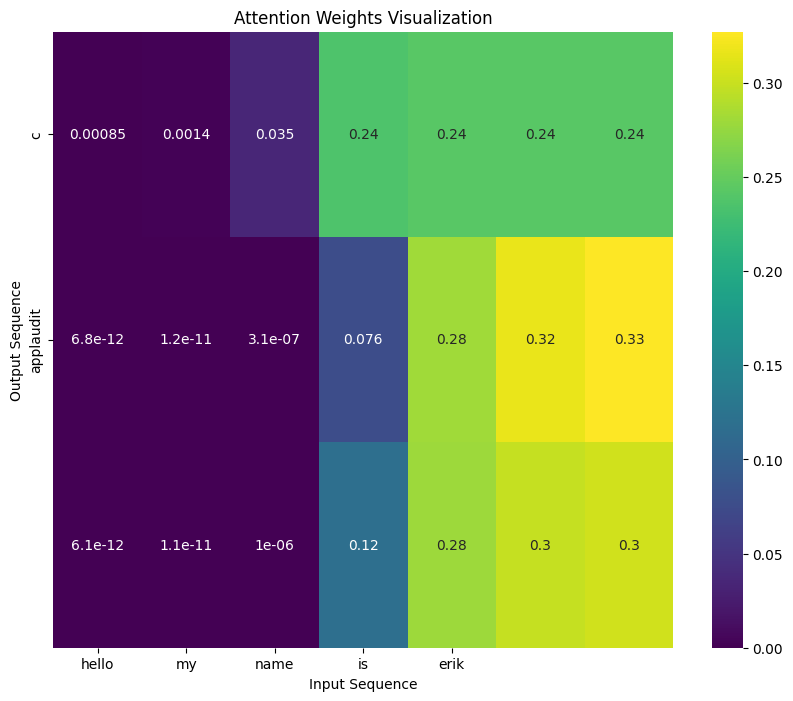

c applaudit


In [600]:
input_text = "hello my name is erik"
translated_text = translate_text(input_text, model, dataset)
print(translated_text)



In [588]:
import numpy as np

# Your original 4D array
attention_weights = np.array(
    [[[[2.6675654e-04],
       [2.8534986e-03],
       [1.2647720e-01],
       [2.8842121e-01],
       [2.9085359e-01],
       [2.9112777e-01]]],

     [[[1.6475365e-12],
       [2.0169423e-11],
       [3.7035430e-04],
       [2.7286166e-01],
       [3.5779631e-01],
       [3.6897168e-01]]],

     [[[1.6858546e-12],
       [2.7380266e-11],
       [1.1753261e-03],
       [2.8819010e-01],
       [3.5121849e-01],
       [3.5941610e-01]]]]
)

# Slicing to remove the last two values from each innermost array
adjusted_weights = attention_weights[:, :, :-2]  # Keep all elements except the last two in the innermost array

# Print the adjusted weights to verify
print(adjusted_weights)

<>:5: SyntaxWarning: list indices must be integers or slices, not list; perhaps you missed a comma?
<>:5: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:13: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:21: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:29: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:37: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:45: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:53: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:61: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:69: SyntaxWarning: list indices must be integers or slices, not float; perhaps you

TypeError: list indices must be integers or slices, not float